# [LVV-T2213] - Look-up Table Application from MTMount Elevation Changes

This notebook was originally written by Bo Xin in the [lsst-ts/ts_notebooks] repository.  
It is a modified version with updated commands and simplified steps.

**Make sure you run this notebook on TTS before running at the summit.**

[lsst-ts/ts_notebooks]: https://github.com/lsst-ts/ts_notebooks/blob/develop/bxin/aos2comp/aos2comp.ipynb
[LVV-T2213]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T2213

## Requirements

This notebooks require some extra repositories to be installed locally so it can grab some constants and some look-up tables.  
Here is a list of which repos are these:

* [lsst-ts/ts_cRIOpy]

[lsst-ts/ts_cRIOpy]: https://github.com/lsst-ts/ts_cRIOpy 
[lsst-ts/ts_m1m3support]: https://github.com/lsst-ts/ts_m1m3support

To install them, open a terminal and run the following commands:

```
git clone https://github.com/lsst-ts/ts_cRIOpy $HOME/notebooks/lsst-ts/ts_cRIOpy
git clone https://github.com/lsst-ts/ts_m1m3support.git $HOME/notebooks/lsst-ts/ts_m1m3support
git clone https://github.com/lsst-ts/ts_config_mttcs $HOME/notebooks/lsst-ts/ts_config_mttcs
git clone https://github.com/lsst-sitcom/M2_FEA $HOME/notebooks/lsst-sitcom/M2_FEA
```

And add these lines to your `$HOME/notebooks/.user_setup` file: 

```
setup -j notebooks_vandv -r ~/notebooks/lsst-sitcom/notebooks_vandv
setup -j ts_cRIOpy -r $HOME/notebooks/lsst-ts/ts_cRIOpy
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lsst.sitcom import vandv

exec_info = vandv.ExecutionInfo()
print(exec_info)


Executed by b1quint on 2022-06-09T07:28:56.002.
  Running in pillan03 at tucson



---
## Setup Notebook for Test

- Import all libraries
- Get the remotes ready

In [3]:
test_execution = "LVV-EXXXX"

In [4]:
import asyncio
import os
import yaml

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import time 
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
from datetime import datetime, timedelta

from lsst_efd_client import EfdClient
from lsst.ts import utils, salobj
from lsst.ts.cRIOpy import M1M3FATable
from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType

import lsst.sitcom.vandv as vandv

In [5]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ["LSST_DDS_DOMAIN_ID"])

file:///opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/config/ospl-shmem.xml
tucson
0


In [6]:
logging.basicConfig(format="%(name)s:%(message)s", level=logging.DEBUG)

In [7]:
log = logging.getLogger("setup")
log.level = logging.DEBUG

In [8]:
domain = salobj.Domain()

In [9]:
mtcs = MTCS(domain=domain, log=log)
mtcs.set_rem_loglevel(40)

In [10]:
await mtcs.start_task

[None, None, None, None, None, None, None, None, None, None]

## Helper Functions

In [11]:
async def get_data_from_efd(location, start, end):
    """
    Retrieves data relevant for analysis.
    
    Parameters
    ----------
    location : str
        In which Test Stand are you running this test?
    start : str or datetime
        Start of the time-window.
    end : str or datetime 
        End of the time-window.
    """
    if location == "summit":
        client = EfdClient("summit_efd")
    elif location == "tucson":
        client = EfdClient("tucson_teststand_efd")
    else:
        raise ValueError(
            "Location does not match any valid options {summit|tucson}"
        )
    
    _df_mount_el = await client.select_time_series(
        "lsst.sal.MTMount.elevation", 
        fields="actualPosition", 
        start=start.utc, 
        end=end.utc,
    )
    
    _df_m1m3_101 = await client.select_time_series(
        "lsst.sal.MTM1M3.forceActuatorData",
        fields="zForce101",
        start=start.utc, 
        end=end.utc,
    )
        
    # M2 B1?
    _df_m2 = await client.select_time_series(
        "lsst.sal.MTM2.axialForce",
        fields=[
            "applied0",
            "lutGravity0",
        ],
        start=start.utc, 
        end=end.utc,
    )
    
    # CamHex Y position
    _df_camhex = await client.select_time_series(
        "lsst.sal.MTHexapod.application",
        fields=[
            "position1"
        ],
        index=1,
        start=start.utc, 
        end=end.utc,
    )
    
    # M2Hex Y position
    _df_m2hex = await client.select_time_series(
        "lsst.sal.MTHexapod.application",
        fields=[
            "position1"
        ],
        index=2,
        start=start.utc, 
        end=end.utc,
    )

    # Rename columns
    _df_mount_el.rename(columns={"actualPosition": "mount_el"}, inplace=True)
    _df_m1m3_101.rename(columns={"zForce101": "m1m3_z101"}, inplace=True)
    _df_m2.rename(columns={"applied0": "m2b1_applied", "lutGravity0": "m2b1_gravLut"}, inplace=True)
    _df_camhex.rename(columns={"position1": "camhex_y"}, inplace=True)
    _df_m2hex.rename(columns={"position1": "m2hex_y"}, inplace=True)

    
    # Join dataframes
    _df = _df_mount_el
    
    _df = pd.merge(
        _df, 
        _df_m1m3_101, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
         
    _df = pd.merge(
        _df, 
        _df_m2, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
    
    _df = pd.merge(
        _df, 
        _df_camhex, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )

    _df = pd.merge(
        _df, 
        _df_m2hex, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
    
    return _df

## Start all the components, and put them in an enabled state.

Depending on which test cycle this is being executed in, each component is either a hardware component or a simulator:

- [ ] M1M3
- [ ] M2 
- [ ] M2 Hexapod
- [ ] Camera Hexapod
- [ ] MTMount

The best/simplest way of doing this is running the notebook that executes the [LVV-T2344] test case.  
This notebook puts all the components in a ENABLED state.

[LVV-T2344]: https://github.com/lsst-sitcom/notebooks_vandv/blob/develop/notebooks/proj_sys_eng/sitcom_integration/l3_system_integ/LVV-T2344-Startup_mt_on_level3.ipynb

In [12]:
# Verify that all the components have heartbeats
await mtcs.assert_liveliness()

In [13]:
# Verify that all the components are enabled
await mtcs.assert_all_enabled()

---
## Move mtmount to Zenith

Command the mount to elevation = 90, azimuth = 0, so that we can start m1m3 with LUT in mount telemetry mode).

In [14]:
# await mtcs.rem.mtmount.cmd_moveToTarget.set_start(azimuth=0, elevation=90)
await mtcs.point_azel(az=0, el=90)
await mtcs.stop_tracking()

---
## Get M1M3 Ready

- Raise the mirror,
- Turn on Balance Forces,
- Clear forces

Need to have M1M3 LUT use mount telemetry.

In [15]:
# If M1M3 is not raised yet, use this command to raise it.
await mtcs.raise_m1m3()

In [16]:
# Enables M1M3 Force Balance system using the hardpoints
await mtcs.enable_m1m3_balance_system()

In [17]:
# Resets the Aberration Forces and the Active Optics Forces
await mtcs.reset_m1m3_forces()

In [18]:
# M1M3 LUT use mount telemetry
# todo: how to do that? 

## Get M2 Ready
- Turn on Force Balance system
- Clear forces

In [19]:
# Enabled M2 Force Balance system 
await mtcs.enable_m2_balance_system()

In [20]:
# Resets the Active Optics Forces
await mtcs.reset_m2_forces()

In [21]:
# Need to have M2 LUT use mount telemetry
# todo: how to do that?

## Get CamHex Ready
- Check config 
- Make sure LUT is on, and has valid inputs
- Make sure hex is at LUT position

In [22]:
# Check the configuration
await vandv.hexapod.get_hexapod_configuration(mtcs.rem.mthexapod_1)

MTHexapodID: 1, private_revCode: 047bbc0a, private_sndStamp: 1654193336.1475494, private_rcvStamp: 1654759741.3920221, private_seqNum: 1, private_identity: MTHexapod:1, private_origin: 34213, configurations: _init.yaml, version: v0.8.1-0-g0400d07, url: file:///home/saluser/ts_config_mttcs/MTHexapod/v3, schemaVersion: v3, otherInfo: , priority: 0

Pivot at (0.0, 0.0, 500000.0) microns
 maxXY = 11400.0 microns, maxZ = 13100.0 microns
 maxUV = 0.36 deg, maxW = 0.1 deg


In [23]:
# Enable compensation mode for CamHex
await mtcs.enable_compensation_mode("mthexapod_1")

In [24]:
# Reset the Camera Hexapod position
await mtcs.reset_camera_hexapod_position()

In [25]:
# After resetting the Camera Hexapod position, we want to make sure that 
# the compesation and non-compensation values are the same.
await vandv.hexapod.print_hexapod_uncompensation_values(mtcs.rem.mthexapod_1)
await vandv.hexapod.print_hexapod_compensation_values(mtcs.rem.mthexapod_1)

Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2022-06-06 16:22:31.285524992
Compensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2022-06-09 07:31:01.084146176


In [26]:
# Need to have CamHex LUT use mount telemetry
await vandv.hexapod.check_hexapod_lut(mtcs.rem.mthexapod_1)

Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
compsensation mode enabled? True
mount elevation =  80.00192932041769
mount azimth =  359.6587624682119
rotator angle =  0.0
? temperature =  0.0
x = -0.87
y = -423.47
z = 283.37
u = -0.01
v = 0.00
w = 0.00


## Get M2Hex Ready

- Check config 
- Make sure LUT is on, and has valid inputs
- Make sure M2Hex is at LUT position

In [27]:
# Check the configuration
await vandv.hexapod.get_hexapod_configuration(mtcs.rem.mthexapod_2)

MTHexapodID: 2, private_revCode: 047bbc0a, private_sndStamp: 1654193336.5853574, private_rcvStamp: 1654759741.4693687, private_seqNum: 1, private_identity: MTHexapod:2, private_origin: 35591, configurations: _init.yaml, version: v0.8.1-0-g0400d07, url: file:///home/saluser/ts_config_mttcs/MTHexapod/v3, schemaVersion: v3, otherInfo: , priority: 0

Pivot at (0.0, 0.0, 500000.0) microns
 maxXY = 10500.0 microns, maxZ = 8900.0 microns
 maxUV = 0.175 deg, maxW = 0.05 deg


In [28]:
# Enable compensation mode for M2Hex
await mtcs.enable_compensation_mode("mthexapod_2")

In [29]:
# Reset the M2 Hexapod position
await mtcs.reset_m2_hexapod_position()

In [30]:
# After resetting the Camera Hexapod position, we want to make sure that 
# the compesation and non-compensation values are the same.
await vandv.hexapod.print_hexapod_uncompensation_values(mtcs.rem.mthexapod_2)
await vandv.hexapod.print_hexapod_compensation_values(mtcs.rem.mthexapod_2)

Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2022-06-06 16:22:37.701949696
Compensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2022-06-09 07:31:11.557306880


In [31]:
# Need to have CamHex LUT use mount telemetry
await vandv.hexapod.check_hexapod_lut(mtcs.rem.mthexapod_1)

Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
compsensation mode enabled? True
mount elevation =  80.00192932041769
mount azimth =  359.6587624682119
rotator angle =  0.0
? temperature =  0.0
x = -0.87
y = -423.47
z = 283.37
u = -0.01
v = 0.00
w = 0.00


## Gather Data - Without AO

  * command the mount to elevation =86 deg, azimuth = 0
  * wait 39s
  * command the mount to elevation = 82 deg, azimuth = 0.

In [32]:
# Set this to True when you actually want to run this test
if True:
    t_start = time.Time(utils.current_tai(), format="unix", scale="tai")
    t_start.format = "isot"
    print(f"Gathering data - without AO - Start time: {t_start.utc}")

    await asyncio.sleep(39.)

    # Slew to 86 deg
    await mtcs.point_azel(az=0, el=86)
    await asyncio.sleep(39.)

    # Slew to 82 deg
    await mtcs.point_azel(az=0, el=82)
    await asyncio.sleep(39.)

    t_end = time.Time(utils.current_tai(), format="unix", scale="tai")
    t_end.format = "isot"
    print(f"Gathering data - without AO - End time: {t_end.utc}")
    
    await mtcs.stop_tracking()

Gathering data - without AO - Start time: 2022-06-09T07:31:22.031


Gathering data - without AO - End time: 2022-06-09T07:34:00.143


## Plot Data

In [35]:
# t_start = "2022-06-06T16:33:47.387"
# t_start = time.Time(t_start, format="isot", scale="tai")

# t_end = "2022-06-06T16:36:25.569"
# t_end = time.Time(t_end, format="isot", scale="tai")

## Plot Optics vs Time

Plot the following as a function of time during the above process:

- mount elevation
- m1m3 actuator 101 z force
- m2 actuator B1 force
- camera hex y position
- m2 hex y position

In [36]:
df = await get_data_from_efd(
    exec_info.loc, 
    t_start, 
    t_end)

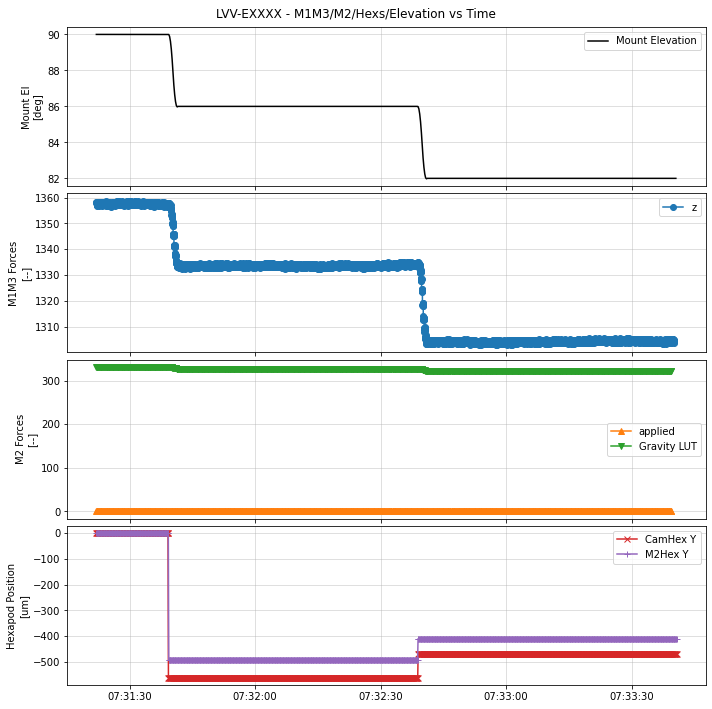

In [37]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, sharex=True)

axs[0].plot(df["mount_el"].dropna(), "k", label="Mount Elevation")
axs[0].set_ylabel("Mount El\n[deg]")

axs[1].plot(df["m1m3_z101"].dropna(), "C0o-", label="z")
axs[1].set_ylabel("M1M3 Forces\n[--]")

axs[2].plot(df["m2b1_applied"].dropna(), "C1^-", label="applied")
axs[2].plot(df["m2b1_gravLut"].dropna(), "C2v-", label="Gravity LUT")
axs[2].set_ylabel("M2 Forces\n[--]")

axs[3].plot(df["camhex_y"].dropna(), "C3x-", label="CamHex Y")
axs[3].plot(df["m2hex_y"].dropna(), "C4+-", label="M2Hex Y")
axs[3].set_ylabel("Hexapod Position\n[um]")

for ax in axs:
    ax.grid(":", alpha=0.5)
    ax.legend()

fig.suptitle(f"{test_execution} - M1M3/M2/Hexs/Elevation vs Time")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m1m3_m2_hexs_el_vs_time.png")
plt.show()

## M1M3 Elevation Forces vs LUT

Check the M1M3 elevation forces match what we expect from the implemented LUT.

In [38]:
elevation = await mtcs.rem.mtmount.tel_elevation.aget(timeout=10.)
print(elevation, "\n")

private_revCode: b99a7959, private_sndStamp: 1654760060.567301, private_rcvStamp: 1654760060.5677433, private_seqNum: 608148, private_identity: MTMount, private_origin: 44741, actualPosition: 82.0, demandPosition: 82.0, actualVelocity: 0.0, demandVelocity: 0.0, actualAcceleration: 0.0, actualTorque: 0.0, timestamp: 1654760060.56604 



The look-up table for X has basically zeroes.  
At least for now.  
So it does not make much sense evaluating it now.

The lut for Y has non-zeroes and zeroes values.  
in order to compare, we can drop the zeroes components.

For z, we are good. We can perform a direct comparison.

In [40]:
lut_el_xforces = vandv.m1m3.lut_elevation_xforces(elevation.actualPosition)
lut_el_yforces = vandv.m1m3.lut_elevation_yforces(elevation.actualPosition)
lut_el_zforces = vandv.m1m3.lut_elevation_zforces(elevation.actualPosition)

In [41]:
fel = await mtcs.rem.mtm1m3.evt_appliedElevationForces.aget(timeout=10.)

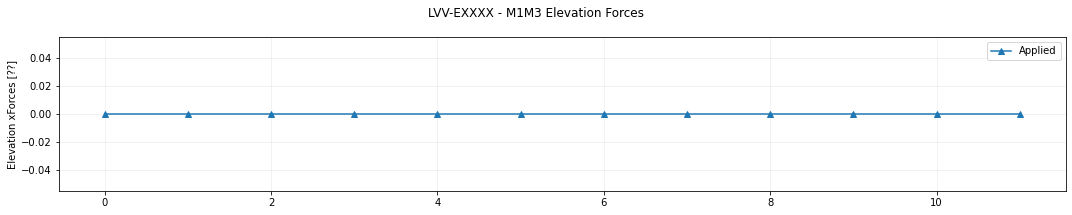

In [42]:
fig, ax = plt.subplots(figsize=(15, 3))

ax.plot(fel.xForces, "C0^-", label="Applied")
ax.set_ylabel("Elevation xForces [??]")
ax.grid(":", alpha=0.2)
ax.legend()

fig.suptitle(f"{test_execution} - M1M3 Elevation Forces")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m1m3_fel_xForces.png")
plt.show()

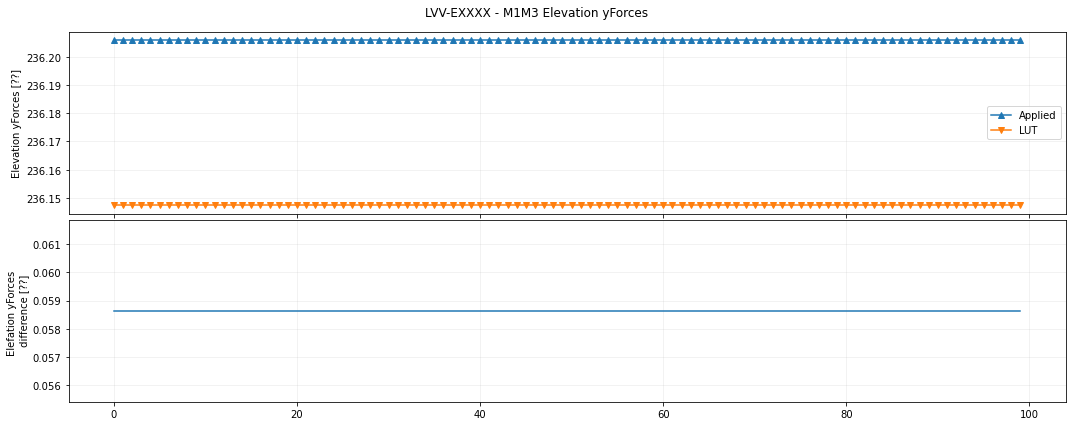

In [43]:
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)

axs[0].plot(fel.yForces, "C0^-", label="Applied")
axs[0].plot(lut_el_yforces[lut_el_yforces != 0], "C1v-", label="LUT")
axs[0].set_ylabel("Elevation yForces [??]")
axs[0].grid(":", alpha=0.2)
axs[0].legend()

axs[1].plot(fel.yForces - lut_el_yforces[lut_el_yforces != 0], label="Applied - LUT forces")
axs[1].set_ylabel("Elefation yForces \n difference [??]")
axs[1].grid(":", alpha=0.2)

fig.suptitle(f"{test_execution} - M1M3 Elevation yForces")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m1m3_fel_yForces.png")
plt.show()

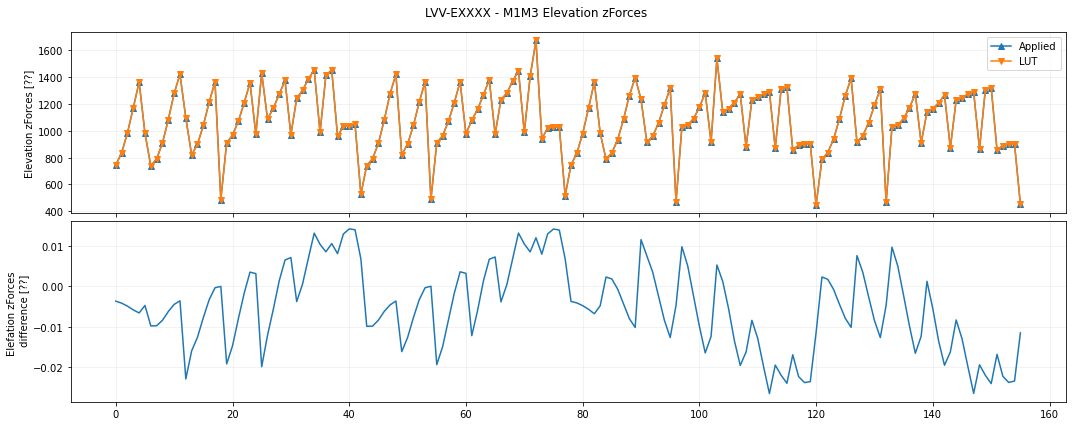

In [44]:
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)

axs[0].plot(fel.zForces, "C0^-", label="Applied")
axs[0].plot(lut_el_zforces, "C1v-", label="LUT")
axs[0].set_ylabel("Elevation zForces [??]")
axs[0].grid(":", alpha=0.2)
axs[0].legend()

axs[1].plot(fel.zForces - lut_el_zforces, label="Applied - LUT forces")
axs[1].set_ylabel("Elefation zForces \n difference [??]")
axs[1].grid(":", alpha=0.2)

fig.suptitle(f"{test_execution} - M1M3 Elevation zForces")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m1m3_fel_zForces.png")
plt.show()

The following plots are extracted from Bo's Notebooks.  
The originals are in [lsst-ts/ts_notebooks/bxin/ptg2m1m3].

[lsst-ts/ts_notebooks/bxin/ptg2m1m3]: https://github.com/lsst-ts/ts_notebooks/blob/develop/bxin/ptg2m1m3/m1m3_diagnostic.ipynb

In [45]:
fel = await mtcs.rem.mtm1m3.evt_appliedElevationForces.aget(timeout=10.)
faz = await mtcs.rem.mtm1m3.evt_appliedAzimuthForces.aget(timeout=10.)
fth = await mtcs.rem.mtm1m3.evt_appliedThermalForces.aget(timeout=10.)
fba = await mtcs.rem.mtm1m3.evt_appliedBalanceForces.aget(timeout=10.)
fac = await mtcs.rem.mtm1m3.evt_appliedAccelerationForces.aget(timeout=10.)
fve = await mtcs.rem.mtm1m3.evt_appliedVelocityForces.aget(timeout=10.)
fst = await mtcs.rem.mtm1m3.evt_appliedStaticForces.aget(timeout=10.)
fab = await mtcs.rem.mtm1m3.evt_appliedAberrationForces.aget(timeout=10.)
fof = await mtcs.rem.mtm1m3.evt_appliedOffsetForces.aget(timeout=10.)
fao = await mtcs.rem.mtm1m3.evt_appliedActiveOpticForces.aget(timeout=10.)
fapp = await mtcs.rem.mtm1m3.evt_appliedForces.aget(timeout=10.)

ftel = await mtcs.rem.mtm1m3.tel_forceActuatorData.next(flush=True, timeout=10.)

In [48]:
def plotForces(fel, fba, fst, fao):
    
    # Get the position of the actuators
    fat = np.array(M1M3FATable.FATABLE)
    xact = np.float64(fat[:, M1M3FATable.FATABLE_XPOSITION])
    yact = np.float64(fat[:, M1M3FATable.FATABLE_YPOSITION])
        
    # Create the plot
    fig, ax = plt.subplots(3,1, figsize=(15,8))
    print(fel.xForces)
    ax[0].plot(fel.xForces, '-o', label='elevation');
    ax[0].plot(fba.xForces, label='FB')
    ax[0].plot(fst.xForces, label='static')
    ax[0].plot(ftel.xForce, '-v', label='measured')
    ax[0].legend()
    ax[0].set_title('XForces')
    
    ax[1].plot(fel.yForces, '-o', label='elevation');
    ax[1].plot(fba.yForces, label='FB')
    ax[1].plot(fst.yForces, label='static')
    ax[1].plot(ftel.yForce, '-v', label='measured')
    ax[1].legend()
    ax[1].set_title('YForces')
    ax[2].plot(fel.zForces, '-o', label='elevation');
    ax[2].plot(fba.zForces, label='FB')
    ax[2].plot(fst.zForces, label='static')
    ax[2].plot(fao.zForces, label='AOS')
    ax[2].plot(ftel.zForce, '-v', label='measured')
    ax[2].set_title('ZForces')
    ax[2].legend()
    
    fig2, ax=plt.subplots( 1,3, figsize = [15,4])
    aa = np.array(fao.zForces)
    img = ax[0].scatter(xact, yact, c=aa)
    ax[0].axis('equal')
    ax[0].set_title('AOS forces')
    fig.colorbar(img, ax=ax[0])

    aa = np.array(fel.zForces)
    img = ax[1].scatter(xact, yact, c=aa)
    ax[1].axis('equal')
    ax[1].set_title('elevation forces')
    fig.colorbar(img, ax=ax[1])
    
    aa = np.array(fst.zForces)
    img = ax[2].scatter(xact, yact, c=aa)
    ax[2].axis('equal')
    ax[2].set_title('static forces')
    fig.colorbar(img, ax=ax[2])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


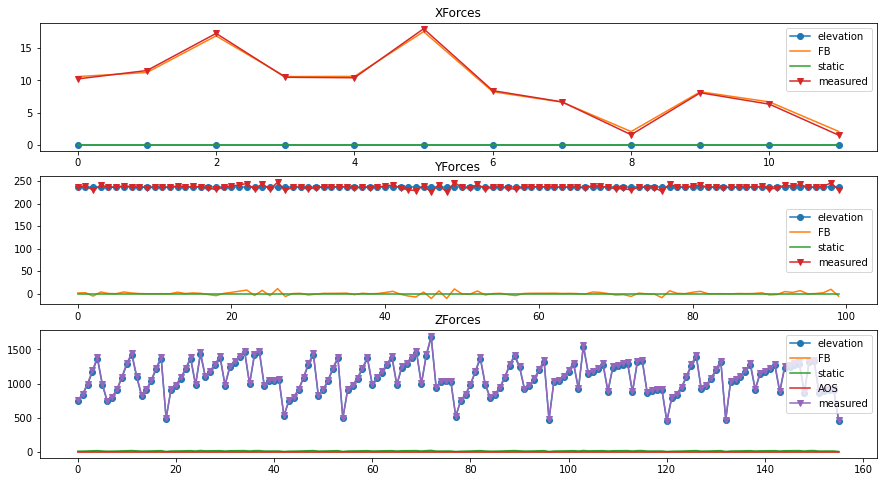

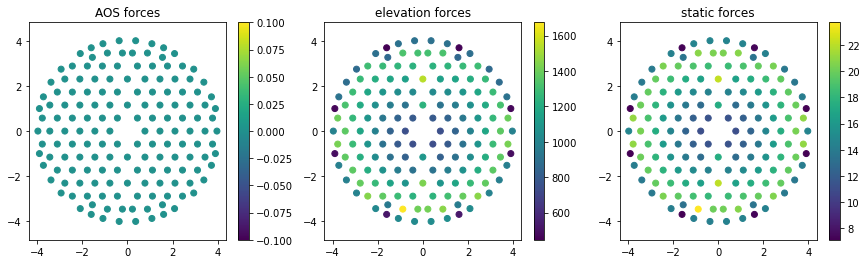

In [49]:
plotForces(fel, fba, fst, fao)

## M2 Elevation Forces vs LUT

Check the M2 elevation forces match what we expect from the implemented LUT.

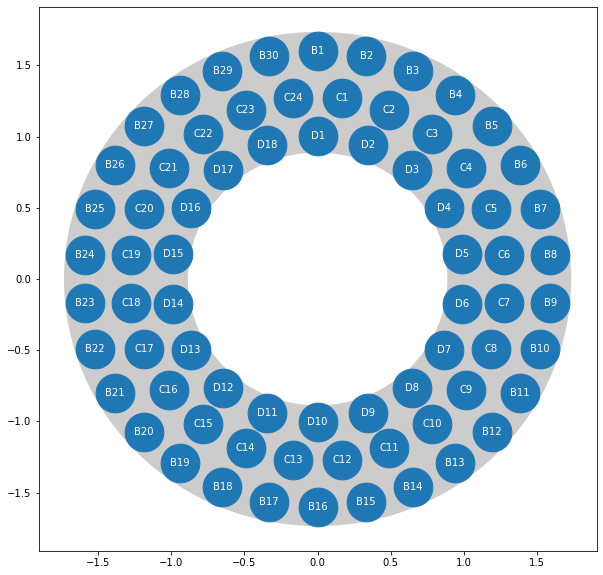

In [50]:
vandv.m2.plot_m2_actuators()

In [51]:
axialForces = await mtcs.rem.mtm2.tel_axialForce.aget(timeout=2)
tangentForces = await mtcs.rem.mtm2.tel_tangentForce.aget(timeout=2)

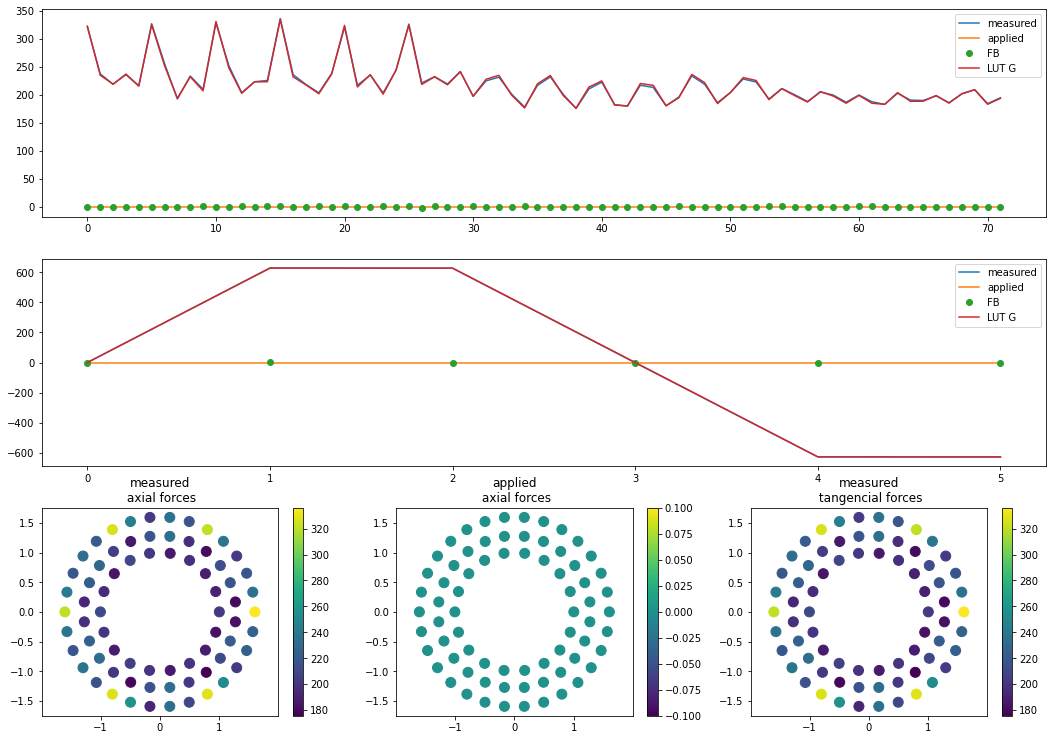

In [52]:
vandv.m2.plotM2Forces(axialForces, tangentForces)

## CamHex Vs LUT

Check the camera hexapod LUT compensations match what we expect from the implemented LUT

In [53]:
a = mtcs.rem.mthexapod_1.evt_compensationOffset.get()
elevCoeff, tCoeff = vandv.hexapod.coeffs_from_lut(index=1)
elev = a.elevation

await vandv.hexapod.print_hexapod_position(mtcs.rem.mthexapod_1)    
await vandv.hexapod.print_predicted_compensation(elevCoeff, elev)
await vandv.hexapod.print_hexapod_uncompensation_values(mtcs.rem.mthexapod_1)
await vandv.hexapod.print_hexapod_compensation_values(mtcs.rem.mthexapod_1)

Current Hexapod position
     -0.85    -468.95     288.05  -0.012815  -0.000000   0.000000
Predicted LUT compensation:
     -0.88    -468.93     288.01      -0.01       0.00       0.00
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2022-06-06 16:22:31.285524992
Compensated position
     -0.88    -468.93     288.01     -0.012815   0.000000   0.000000    2022-06-09 07:33:15.884748288


## M2Hex vs LUT

In [54]:
a = mtcs.rem.mthexapod_1.evt_compensationOffset.get()
elevCoeff, tCoeff = vandv.hexapod.coeffs_from_lut(index=2)
elev = a.elevation

await vandv.hexapod.print_hexapod_position(mtcs.rem.mthexapod_2)    
await vandv.hexapod.print_predicted_compensation(elevCoeff, elev)
await vandv.hexapod.print_hexapod_uncompensation_values(mtcs.rem.mthexapod_2)
await vandv.hexapod.print_hexapod_compensation_values(mtcs.rem.mthexapod_2)

Current Hexapod position
     -2.40    -409.69     304.92  -0.004816  -0.000000  -0.000000
Predicted LUT compensation:
     -2.41    -409.71     304.88      -0.00       0.00       0.00
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2022-06-06 16:22:37.701949696
Compensated position
     -2.41    -409.71     304.88     -0.004815   0.000000   0.000000    2022-06-09 07:33:15.840717056


### Close up

In [55]:
# Put the telescope back to the original position
# Specially if running at TTS
target = mtcs.radec_from_azel(az=0, el=80)

await mtcs.slew_icrs(ra=target.ra, dec=target.dec, rot_type=RotType.Physical, rot=0)
await mtcs.stop_tracking()

In [56]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtaos"])

In [57]:
await mtcs.lower_m1m3()

In [58]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtm1m3"])

In [59]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtm2"])

In [60]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mthexapod_1"])

In [61]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mthexapod_2"])

In [62]:
if exec_info.loc == "summit":
    await mtcs.standby()

else:
    # Bring the system back to the original state
    await mtcs.set_state(
        state=salobj.State.ENABLED,
        components=[
            "mtm1m3", 
            "mtm2",
            "mthexapod_1",
            "mthexapod_2",
            "mtaos",
        ],
        overrides={
            "mtm1m3": "Default"
        }
    )

## Wrap Up

In [ ]:
await mtcs.lower_m1m3()

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtm1m3", "mtm2", "mthexapod_1", "mthexapod_2"])

In [ ]:
await mtcs.set_state(state=salobj.State.ENABLED, components=["mtm2", "mthexapod_1", "mthexapod_2"])